<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Transfer_DenseNet121_50_10_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DenseNet121**

# Check GPU

In [1]:
!nvidia-smi

Fri Jun 12 16:16:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

# Data

## Clone Data

In [3]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-10-40

Cloning into 'PJ61403_DATA_split_new2'...
remote: Enumerating objects: 404, done.
remote: Total 404 (delta 0), reused 0 (delta 0), pack-reused 404
Receiving objects: 100% (404/404), 76.59 MiB | 38.09 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (997/997), done.


## Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100

BATCH_SIZE = 32

LR = 1e-3

In [0]:
train_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test'

### Data Augmentation

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 22 images belonging to 4 classes.
Found 101 images belonging to 4 classes.


## Base Model

In [0]:
base_model = tf.keras.models.load_model('/content/6_scratch_CW_densenet121_84_model.h5')

In [12]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
num_layers = len(base_model.layers)

In [14]:
num_layers

429

## New Model

In [0]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

fc = base_model.layers[num_layers-2].output
fc = Dense(32, activation='relu')(fc)
fc = Dense(16, activation='relu')(fc)
prediction = Dense(4, activation='softmax')(fc)

new_model = Model(inputs=base_model.input,outputs=prediction)

new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [16]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='/content//content/pj61403_densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [18]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - 6s 1s/step - loss: 1.3918 - accuracy: 0.2397 - val_loss: 1.1520 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 4s 983ms/step - loss: 1.0287 - accuracy: 0.5455 - val_loss: 0.9824 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 4s 935ms/step - loss: 0.8596 - accuracy: 0.6033 - val_loss: 0.8035 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 4s 1s/step - loss: 0.7173 - accuracy: 0.7603 - val_loss: 0.6650 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 4s 954ms/step - loss: 0.5511 - accuracy: 0.8843 - val_loss: 0.5780 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 4s 945ms/step - loss: 0.4782 - accuracy: 0.9174 - val_loss: 0.5167 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 4s 968ms/step - loss: 0.3697 - 

# Graph

## Accuraccy

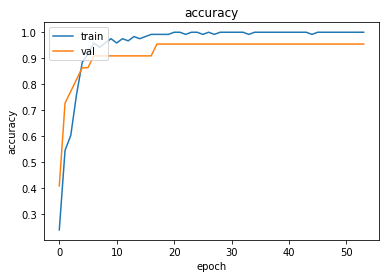

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

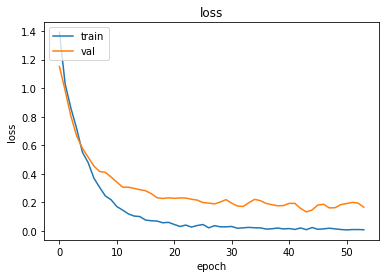

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = tf.keras.models.load_model('/content//content/pj61403_densenet121_model.h5')

In [0]:
num_test_files = len(test_generator.filenames)

In [0]:
test_generator.reset()

In [0]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

Confusion matrix, without normalization
[[27  0  0  0]
 [ 0 24  0  0]
 [ 0  0 25  1]
 [ 1  0  0 23]]


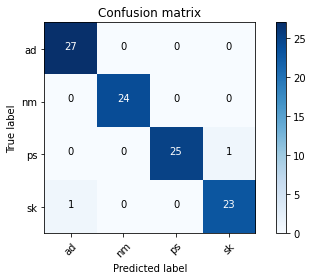

In [25]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.96153846 0.03846154]
 [0.04166667 0.         0.         0.95833333]]


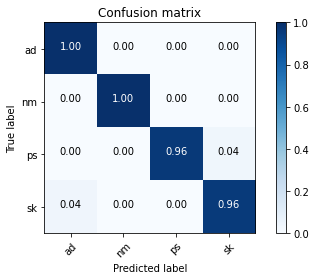

In [26]:
plot_confusion_matrix(cm, classes_names, True)

In [27]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[27  0  0  0]
 [ 0 24  0  0]
 [ 0  0 25  1]
 [ 1  0  0 23]]
Classification Report
              precision    recall  f1-score   support

          ad       0.96      1.00      0.98        27
          nm       1.00      1.00      1.00        24
          ps       1.00      0.96      0.98        26
          sk       0.96      0.96      0.96        24

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101



In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [29]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 1.0000
specificity: 1.0000


# Grad-CAM

In [0]:
last_conv2d = 'conv5_block16_2_conv'

## AD

In [0]:
ad_img = '/content/PJ61403_DATA_split_new2/crop_split_classes_data/test/ad/ad6.jpg'

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ad_img, layer_name=last_conv2d)

## NM

In [0]:
nm_img = '/content/PJ61403_DATA_split_new2/crop_split_classes_data/test/nm/nm4.jpg'

In [37]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

FileNotFoundError: ignored

## PS

In [0]:
ps_img = '/content/PJ61403_DATA_split_new2/crop_split_classes_data/test/ps/ps3.jpg'

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

## SK

In [0]:
sk_img = '/content/PJ61403_DATA_split_new2/crop_split_classes_data/test/sk/sk4.jpg'

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)